YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


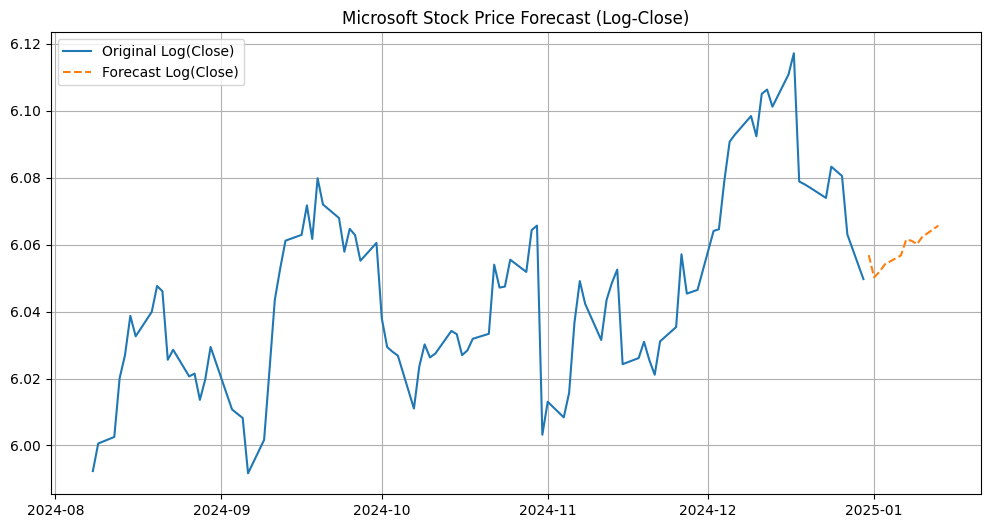

In [1]:
# Install required libraries
!pip install yfinance statsmodels matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Step 1: Load Microsoft Stock Data
msft = yf.download("MSFT", start="2015-01-01", end="2024-12-31")
data = msft[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Log transformation
data_log = np.log(data)

# Step 3: Differencing to achieve stationarity
data_diff = data_log.diff().dropna()

# Step 4: Fit VAR model
model = VAR(data_diff)
lag_order = model.select_order(maxlags=15)
selected_lag = lag_order.aic
model_fitted = model.fit(selected_lag)

# Step 5: Forecasting
n_forecast = 10
forecast_input = data_diff.values[-selected_lag:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=data_diff.index[-1], periods=n_forecast+1, freq='B')[1:], columns=data_diff.columns)

# Step 6: Revert differencing to get actual values
def invert_transformation(train, forecast):
    forecast_copy = forecast.copy()
    for col in train.columns:
        forecast_copy[col] = forecast[col].cumsum() + train[col].iloc[-1]
    return forecast_copy

forecast_reverted = invert_transformation(data_log, forecast_df)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.plot(data_log['Close'][-100:], label='Original Log(Close)')
plt.plot(forecast_reverted['Close'], label='Forecast Log(Close)', linestyle='dashed')
plt.title('Microsoft Stock Price Forecast (Log-Close)')
plt.legend()
plt.grid(True)
plt.show()
